# CNN MODEL 

This model is used to convert ASL sign language images into text. 
For this project we used the ASL alphabet dataset: https://www.kaggle.com/datasets/grassknoted/asl-alphabet

## Import all the necessary libraries

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Read the data

We checked the structure of the dataset and counted the number of available images for each class. 

In [82]:
# Define the directory containing your data
data_dir = 'asl_alphabet_train'

# Initialize a list to store the data
data = []

# Loop through each folder and file in the directory
for label in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, label)): # check if it's a directory
        for image in os.listdir(os.path.join(data_dir, label)):
            image_path = os.path.join(data_dir, label, image)
            data.append([image_path, label])

# Create a DataFrame
asl_train_df = pd.DataFrame(data, columns = ['image_path', 'label'])

# Show the first few rows of the DataFrame
asl_train_df.head()


,image_path,label
0,asl_alphabet_train/R/R2837.jpg,R
1,asl_alphabet_train/R/R2189.jpg,R
2,asl_alphabet_train/R/R1480.jpg,R
3,asl_alphabet_train/R/R1494.jpg,R
4,asl_alphabet_train/R/R2823.jpg,R


In [83]:
asl_train_df.shape # print the dataset shape

(87000, 2)

In [84]:
asl_train_df['label'].value_counts() # show the number of images for each class

R          3000
M          3000
P          3000
Y          3000
L          3000
K          3000
B          3000
E          3000
X          3000
Q          3000
V          3000
D          3000
C          3000
J          3000
space      3000
U          3000
nothing    3000
del        3000
H          3000
O          3000
F          3000
A          3000
S          3000
T          3000
Z          3000
G          3000
N          3000
I          3000
W          3000
Name: label, dtype: int64

We showed one example of image for each class. 

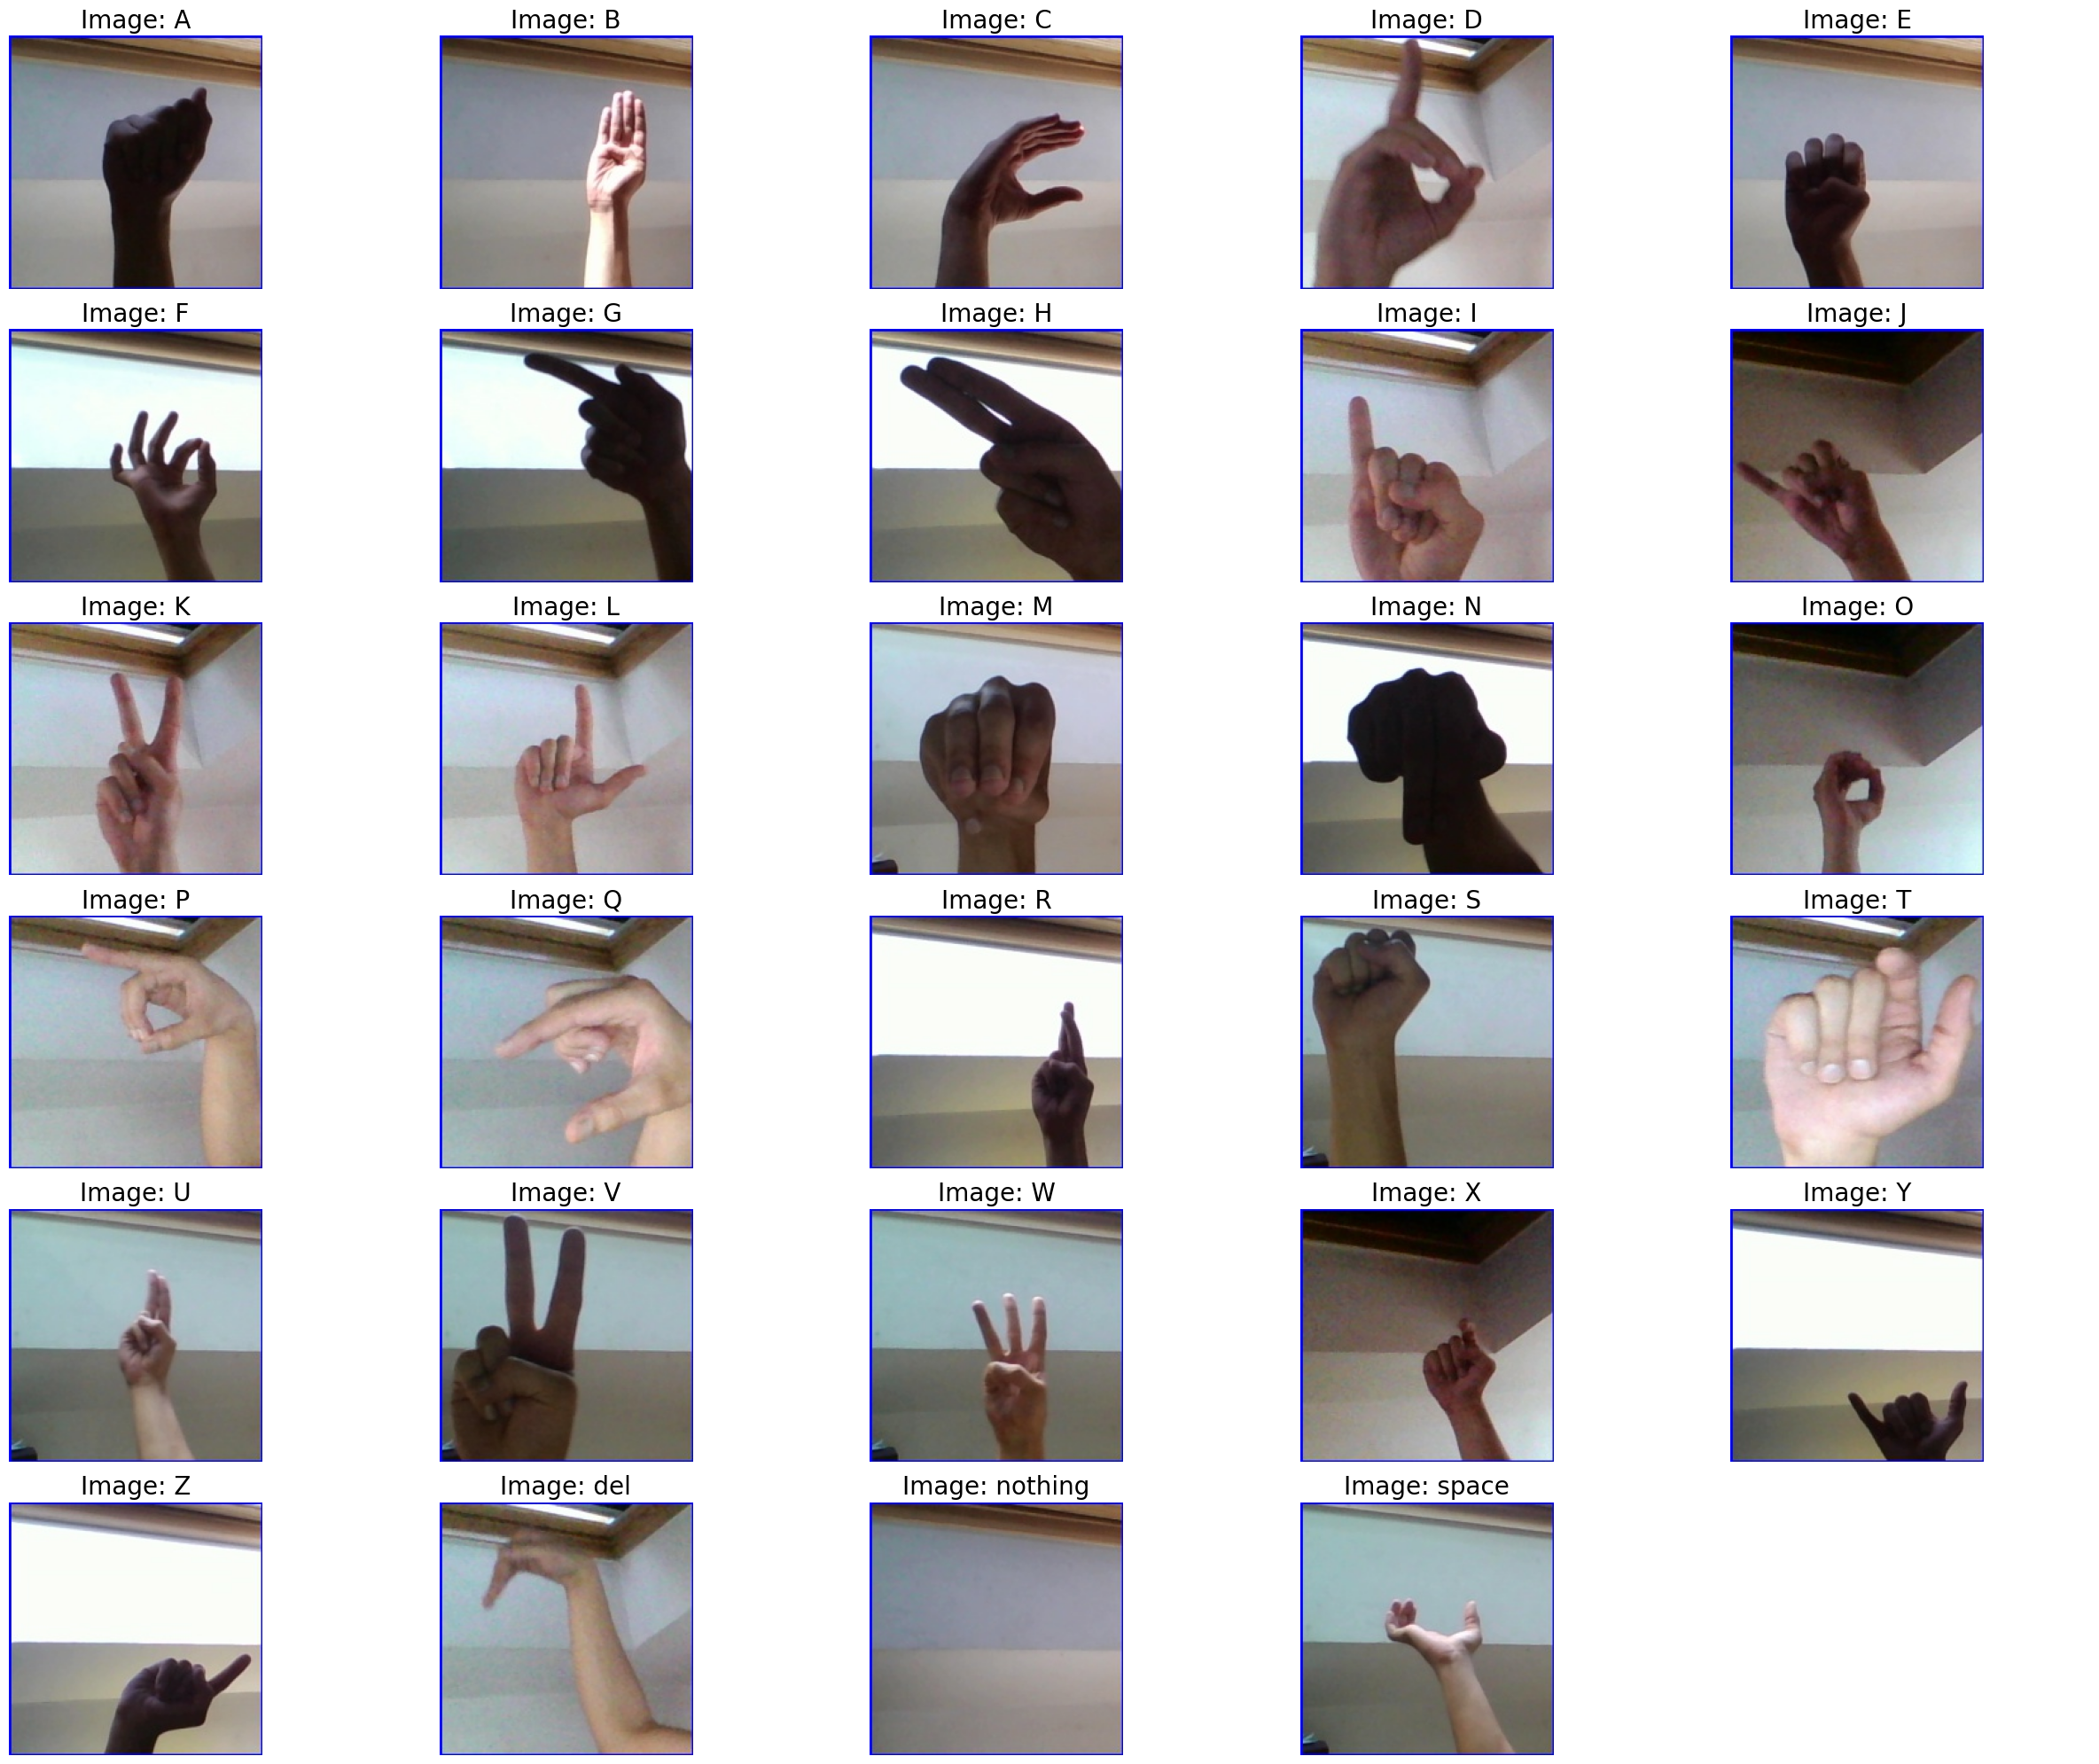

In [85]:
# Show one image for each class
asl_sample = asl_train_df.drop_duplicates(subset = "label") # select a sample from asl_train_df by removing duplicated from the label column
asl_sample = asl_sample.sort_values('label') # sort asl_sample based on the label column

# Select the image_files
image_files = asl_sample['image_path']

# Calculate number of rows needed for 5 images per row
num_rows = (len(image_files) + 4) // 5 # this will automatically round up if not a full row

# Plot the images
fig, axes = plt.subplots(nrows = num_rows, ncols = 5, figsize = (25, 20)) # the figure size to better fit 5 columns
axes = axes.flatten() # flatten the axes array to simplify indexing

for i, img_path in enumerate(image_files):
    img = Image.open(img_path) # open the image
    ax = axes[i] # get the appropriate subplot
    ax.imshow(img, cmap = 'gray') # display the image
    ax.axis('off') # turn off the axis
    ax.set_title(f'Image: {os.path.dirname(img_path).split("/")[1]}', fontsize = 20) # set title with the image filename

# Handle any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off') # turn off the axis for unused subplot

plt.tight_layout()
plt.savefig('sign_language.png')
plt.show()

## EDA

We created a countplot to show the number of images for each class. 

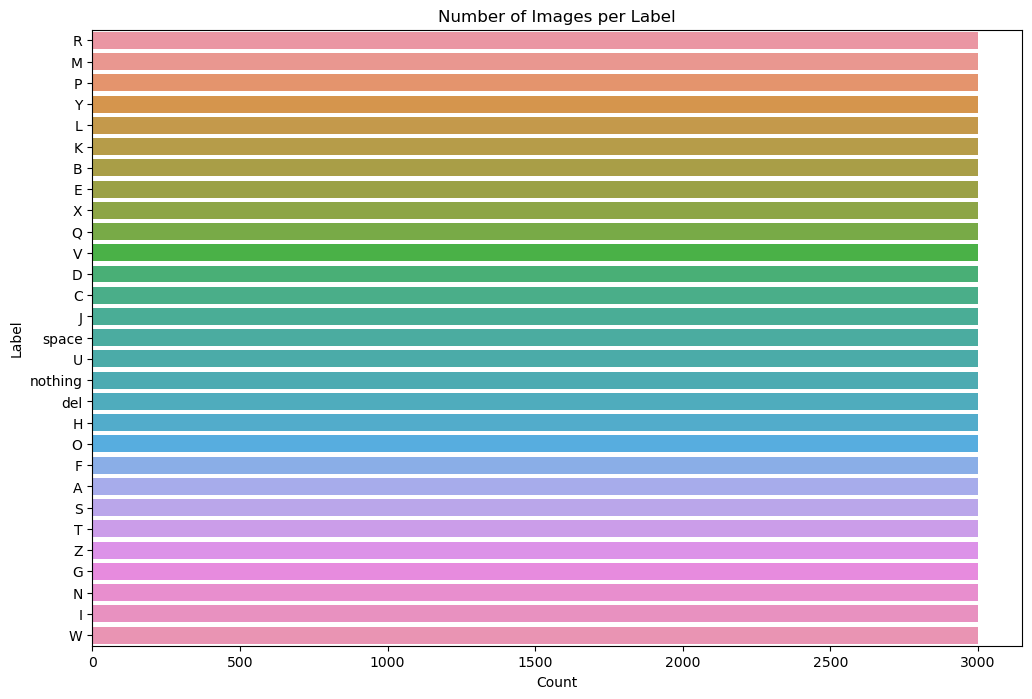

In [86]:
# Plot the number of images for each class
plt.figure(figsize = (12, 8)) # set the figure size
sns.countplot(y = 'label', data = asl_train_df, order = asl_train_df['label'].value_counts().index) # create a countplot
plt.title('Number of Images per Label') # set title
plt.xlabel('Count') # set x-axis label
plt.ylabel('Label') # set y-axis label
plt.show() # show the plot

#### Feature extraction (mean pixel intensity & standard deviation)

We extracted mean pixel intesity and standard deviation from each image to visualize the correlation matrix and the scatter density plot. 

In image processing and analysis, feature extraction such as mean pixel intensity and standard deviation is crucial for distilling complex image data into more interpretable, numerical forms. 

Mean pixel intensity provides a measure of the overall brightness or luminance of an image, which can be critical for tasks that involve brightness normalization or thresholding. 

Standard deviation, on the other hand, measures the variability or contrast within the pixel values, offering insights into the texture and detail present in the image. 

In [87]:
# Define a function to extract mean intensity from an image
def extract_mean_intensity(image_path):
    image = Image.open(image_path)
    image = image.convert('L') # convert to grayscale
    array = np.array(image)
    return np.mean(array)

# Define a function to extract standard deviation of intensity from an image
def extract_std_deviation(image_path):
    image = Image.open(image_path)
    image = image.convert('L') # convert to grayscale
    array = np.array(image)
    return np.std(array)

# Apply feature extraction to each image in the DataFrame
asl_train_df['mean_intensity'] = asl_train_df['image_path'].apply(extract_mean_intensity)
asl_train_df['std_deviation'] = asl_train_df['image_path'].apply(extract_std_deviation)
asl_train_df.head()

,image_path,label,mean_intensity,std_deviation
0,asl_alphabet_train/R/R2837.jpg,R,165.111875,78.132191
1,asl_alphabet_train/R/R2189.jpg,R,83.790900,57.797780
2,asl_alphabet_train/R/R1480.jpg,R,137.466650,39.185032
3,asl_alphabet_train/R/R1494.jpg,R,137.169000,39.003761
4,asl_alphabet_train/R/R2823.jpg,R,164.528475,79.455064


#### Correlation Matrix plot between brightness and contrast

The correlation matrix plot, showing a negative correlation between these two features, suggests that images with higher average brightness tend to have less contrast and variability in their pixel values. Understanding this relationship helps in optimizing image processing tasks and improving algorithms for tasks like image classification, where consistent image quality can influence performance.

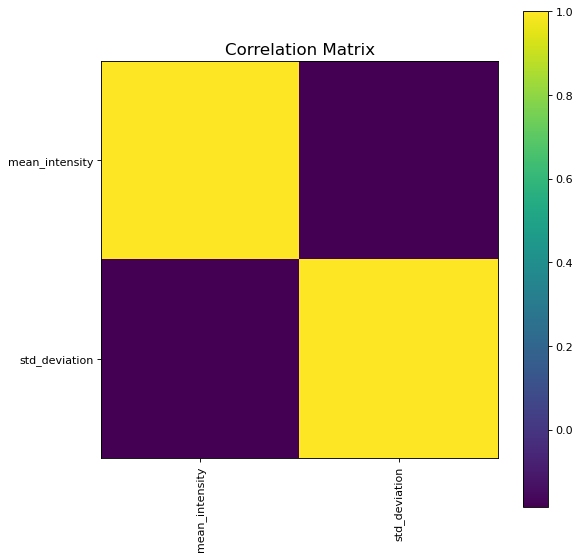

In [88]:
# Function to plot the correlation matrix between brightness and contrast
def plotCorrelationMatrix(df, graphWidth):
    df_numeric = df.select_dtypes(include=[np.number]) # select only numeric columns
    if df_numeric.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df_numeric.shape[1]}) is less than 2')
        return
    corr = df_numeric.corr()
    plt.figure(num = None, figsize = (graphWidth, graphWidth), dpi = 80, facecolor = 'w', edgecolor = 'k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize = 15)
    plt.savefig('CM_preprocessing.png')
    plt.show()

# Plot the correlation matrix
plotCorrelationMatrix(asl_train_df, graphWidth = 8)

#### Scatter and density plot

The scatter and density plot generated from ASL alphabet image dataset provides crucial insights into the relationships between mean intensity and standard deviation of pixel values. 

The density plots indicate predominant brightness levels and variability in image contrast, which are important for understanding image characteristics. 

The scatter plot reveals a slight positive correlation between mean intensity and standard deviation, suggesting these features are somewhat related but still provide independent information. 

This visualization is essential for guiding feature selection and engineering in machine learning models aimed at classifying ASL signs. Overall, it helps ensure that models are trained on informative, non-redundant features, potentially enhancing classification accuracy.

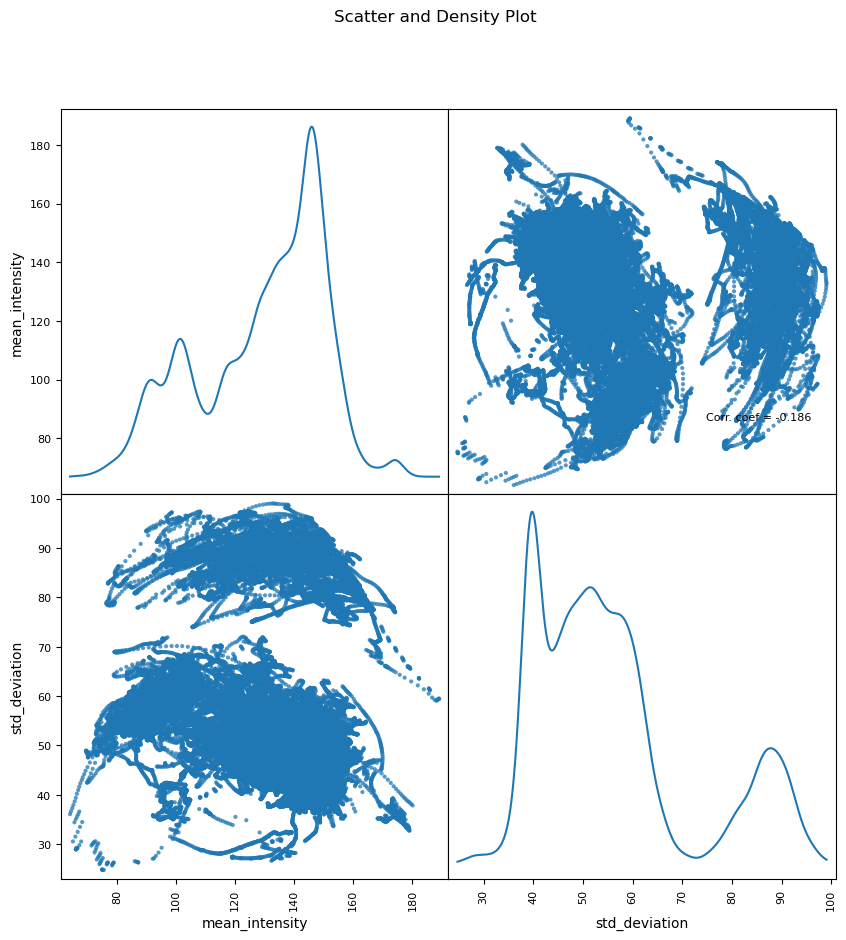

In [89]:
# Function to plot the scatter and density plot
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number]) # keep only numerical columns
    df = df.dropna(axis = 1) # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns with more than 1 unique value
    columnNames = list(df)
    if len(columnNames) > 10: # limit the number of columns to prevent overcrowding
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha = 0.75, figsize = [plotSize, plotSize], diagonal = 'kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate(f'Corr. coef = {corrs[i, j]:.3f}', (0.8, 0.2), xycoords = 'axes fraction', ha = 'center', va = 'center', size = textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# Call the function to plot
plotScatterMatrix(asl_train_df, plotSize = 10, textSize = 8)

## Model design

#### Creating the training, validation and testing sets

In [90]:
new_asl_df = asl_train_df.drop(['mean_intensity', 'std_deviation'], axis = 1) # drop the mean_density and std_deviation
new_asl_df.head()

,image_path,label
0,asl_alphabet_train/R/R2837.jpg,R
1,asl_alphabet_train/R/R2189.jpg,R
2,asl_alphabet_train/R/R1480.jpg,R
3,asl_alphabet_train/R/R1494.jpg,R
4,asl_alphabet_train/R/R2823.jpg,R


We used 70% of the data for the training set, 20% for the validation set, and the remaining 10% for the testing set. 

In [91]:
# Split the dataframe into training, validation and testing sets
asl_train, asl_test_val = train_test_split(new_asl_df, test_size = 0.3, shuffle = True, random_state = 42)
asl_val, asl_test = train_test_split(asl_test_val, test_size = 1/3, shuffle = True, random_state = 42)

# Print the shapes of the training, validation and testing sets
print("Training set shape:", asl_train.shape)
print("Validation set shape:", asl_val.shape)
print("Test set shape:", asl_test.shape)

Training set shape: (60900, 2)
Validation set shape: (17400, 2)
Test set shape: (8700, 2)


#### Data augmentation

Training images were rescaled and converted to grayscale, and numerous augmentation techniques, such as rotation, shiftig, shearing, zooming and flipping, were applied. 

In [ ]:
%%time  

# Define batch size and image size
batch_size = 32
image_size = (64, 64)

# Initialize the ImageDataGenerator for training with data augmentation parameters
train_generator = ImageDataGenerator(rescale = 1./255, # rescale pixel values to [0, 1]
                                    rotation_range = 10, # randomly rotate images by up to 10 degrees
                                    height_shift_range = 0.1, # randomly shift images vertically by up to 10%
                                    width_shift_range = 0.1, # randomly shift images horizontally by up to 10%
                                    shear_range = 0.1, # apply shear transformations
                                    zoom_range = 0.1, # randomly zoom in on images by up to 10%
                                    horizontal_flip = True, # randomly flip images horizontally
                                    fill_mode = 'nearest') # fill in new pixels with the nearest pixel values

# Initialize the ImageDataGenerator for validation without data augmentation
val_test_generator = ImageDataGenerator(rescale = 1./255) # rescale pixel values to [0, 1]

# Create the training image generator from the dataframe
train_images = train_generator.flow_from_dataframe(asl_train, x_col = 'image_path', y_col = 'label',
                                                   color_mode = 'grayscale', class_mode = 'categorical',
                                                   batch_size = batch_size, target_size = image_size,
                                                   shuffle = True, seed = 0)  

# Create the validation image generator from the dataframe
val_images = val_test_generator.flow_from_dataframe(asl_val, x_col = 'image_path', y_col = 'label',
                                                    color_mode = 'grayscale', class_mode = 'categorical',
                                                    batch_size = batch_size, target_size = image_size) 
                        

#### Model architecture

Our CNN model consists of one input layer, four convolutional layers and three dense layers, with the addition of one output layer. 

The number of filters in the convolutional layers increases from 16 close to the input layer to 128 close to the first dense layer, while the number of units reduces from 512 in the first dense layer to 128 in the last one before the output layer. 

For both convolutional layers and dense layers a “relu” activation function was adopted, while for the output layer a “softmax” function was selected. 

To prevent overfitting and improve model generalization to unseen data, different regularization techniques were employed. There is a max pooling layer of size 2x2 after each of the first three convolutional layers, a global average pooling layer and a batch normalization layer before the first dense layer, and a dropout layer with a dropout rate of 50% after each of the first two dense layers.  

In [ ]:
# Determine the output shape based on the number of unique labels in the training data
output_shape = len(set(train_images.labels))

# Define the model architecture
model = Sequential([
    Input(shape = image_size + (1,), name = 'input_layer'), # input layer with the shape of the images

    Conv2D(16, (3, 3), activation = 'relu'), # first convolutional layer with 16 filters
    MaxPooling2D(pool_size = (2, 2)), # max pooling layer with pool size of 2x2

    Conv2D(32, (3, 3), activation = 'relu'), # second convolutional layer with 32 filters
    MaxPooling2D(pool_size = (2, 2)), # max pooling layer with pool size of 2x2

    Conv2D(64, (3, 3), activation = 'relu'), # third convolutional layer with 64 filters
    MaxPooling2D(pool_size = (2, 2)), # max pooling layer with pool size of 2x2

    Conv2D(128, (3, 3), activation = 'relu'), # fourth convolutional layer with 128 filters
    
    GlobalAveragePooling2D(), # global average pooling layer
    BatchNormalization(), # batch normalization layer

    Dense(512, activation = 'relu'), # first dense layer with 512 units
    Dropout(0.5), # dropout layer with 50% dropout rate

    Dense(256, activation = 'relu'), # second dense layer with 256 units
    Dropout(0.5), # dropout layer with 50% dropout rate

    Dense(128, activation = 'relu'), # third dense layer with 128 units

    Dense(output_shape, activation = 'softmax', name = 'output_layer') # output layer with softmax activation
])

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer = Adam(learning_rate = 1e-3), 
              loss = CategoricalCrossentropy(), 
              metrics = ['accuracy'])

# Print the model summary
model.summary()


## Model training

The model was compiled with the Adam optimizer and a learning rate of 1e-3, which dynamically reduces during training up to 1e-6 in order to minimize the validation loss. We imposed the categorical cross-entropy loss function as the function to be minimized by the optimizer, and the accuracy as the metric to monitor model performance during training. The model was trained for a total of 50 epochs and with a batch size of 32, and the model with the maximum accuracy was saved. 

In [ ]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', # monitor the validation loss
                              factor = 0.2, # factor by which the learning rate will be reduced
                              patience = 10, # number of epochs with no improvement after which learning rate will be reduced
                              min_lr = 1e-6) # lower bound on the learning rate

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', # file path to save the model
                                    monitor = 'val_accuracy', # monitor validation accuracy
                                    save_best_only = True, # save only the best model
                                    mode = 'max', # save the model with the maximum accuracy
                                    verbose = 1) # print messages when saving

# Train the model
history = model.fit(
    train_images, # training data
    epochs = 50, # number of epochs to train
    validation_data = val_images, # validation data
    callbacks = [reduce_lr, model_checkpoint] # list of callbacks to be called during training
)

# Print the training history
print(history.history)

#### Visualize the training and validation loss and accuracy

In [ ]:
# Save the trianing history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

print("Training history saved as training_history.pkl")

In [ ]:
# Load the dictionary from the file
with open('training_history.pkl', 'rb') as file:
    loaded_history_dict = pickle.load(file)

# print(loaded_history_dict)

As demonstrated by the learning curves, training and validation accuracy/loss progressively increases/decreases with the number of epochs until reaching a plateau. This means that the model does not overfit or underfit.

In [ ]:
# Extract the history data
history_dict = loaded_history_dict

# Extract the metrics
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create epochs range for x-axis
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize = (25, 10))
plt.subplot(1, 2, 1)  
plt.plot(epochs, train_acc, 'bo-')
plt.plot(epochs, val_acc, 'ro-')
plt.legend(['Training', 'Validation'], prop = {'size' : 20})
plt.xlabel('Epochs', fontsize = 40)
plt.ylabel('Accuracy', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)  
plt.plot(epochs, train_loss, 'bo-')
plt.plot(epochs, val_loss, 'ro-')
plt.legend(['Training', 'Validation'], prop = {'size' : 20})
plt.xlabel('Epochs', fontsize = 40)
plt.ylabel('Loss', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend()

plt.savefig('Train_Val_Accuracy_Loss')

# Display the plots
plt.show()

#### Model evaluation on the testing set

In [92]:
# Load the model
model = load_model("asl_cnn_model.h5")

In [93]:
# Evaluate testing loss and accuracy

results = model.evaluate(test_images)

print("Test loss:", results[0])
print("Test accuracy :", results[1])

272/272 [==============================] - 11s 39ms/step - loss: 0.0404 - accuracy: 0.9875
Test loss: 0.04039408639073372
Test accuracy : 0.9874712824821472


#### Model predictions on the testing set

In [94]:
class_labels = {v: k for k, v in train_images.class_indices.items()} # extract the class labels

In [95]:
# Function to get the predicted labels in the testing set
def predict_image(image_path, model, class_labels):
    try:
        img = load_img(image_path, target_size = (64, 64), color_mode = 'grayscale')
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis = 0)

        predictions = model.predict(img_array, verbose = 0)
        predicted_class_index = np.argmax(predictions, axis = 1)[0]
        predicted_class = class_labels[predicted_class_index]
        return predicted_class
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return "Error"

# List image files in the testing set
image_files = asl_test['image_path']

# Get predicted labels in the testing set
predicted_labels = []

for img_path in image_files:
    predicted_labels.append(predict_image(img_path, model, class_labels))

In [96]:
# Get the true labels in the testing set
true_labels = asl_test['label'].tolist()

In [97]:
# Print the classification report
print('Classification report: \n', classification_report(true_labels, predicted_labels), '\n')

Classification report: 
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       291
           B       1.00      0.99      0.99       314
           C       0.99      1.00      0.99       326
           D       1.00      1.00      1.00       297
           E       0.97      1.00      0.99       332
           F       1.00      1.00      1.00       283
           G       0.99      0.99      0.99       297
           H       0.97      1.00      0.99       307
           I       0.99      0.98      0.99       305
           J       1.00      0.98      0.99       286
           K       0.99      1.00      0.99       298
           L       0.99      1.00      0.99       328
           M       0.97      0.97      0.97       275
           N       1.00      0.97      0.98       292
           O       1.00      0.97      0.99       299
           P       1.00      1.00      1.00       274
           Q       0.99      1.00      1.00       305
  

Confusion Matrix:


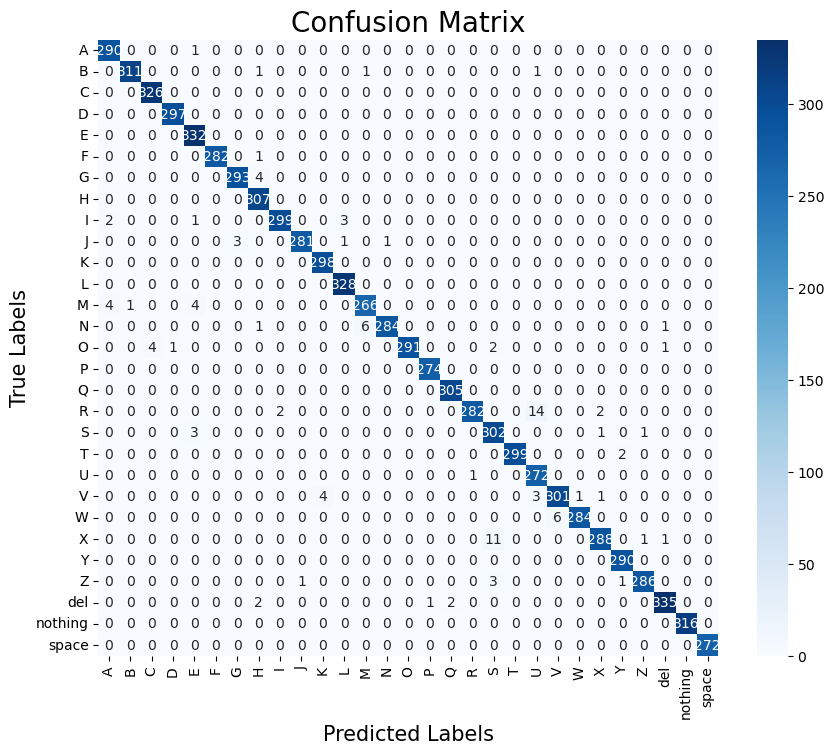

In [100]:
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = list(test_images.class_indices.keys()), yticklabels = list(test_images.class_indices.keys()))
plt.title('Confusion Matrix', fontsize = 20)
plt.xlabel('Predicted Labels', fontsize = 15)
plt.ylabel('True Labels', fontsize = 15)
plt.savefig('Confusion_Matrix')
plt.show()

In [ ]:
plt.figure(num = None, figsize = (graphWidth, graphWidth), dpi = 80, facecolor = 'w', edgecolor = 'k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize = 15)
    plt.savefig('CM_preprocessing.png')
    plt.show()